# Moment Neural Network: a complete guide  

## 0. Table of Content
1. Overview
2. Summation layer
3. Batchnorm layer
4. Activation  
Appendix A: Generalized Dawson functions  
Appendix B: Linear response coefficient and its derivatives  
Appendix C: Proof that batchnorm does not change $\hat{\rho}_{ij}$  

## 1. Overview
A single feedforward layer of MNN takes $(\mu_k,\sigma_k,\rho_{kl})$ from the previous layer as input, and outputs $(\mu_i,\sigma_i,\rho_{ij})$ to the next layer. The MNN layer consists three sublayers: the summation layer, the batchnorm layer, and the activation. The design of the layer is intended to maximize compatibility with the existing framework of pytorch and to minimize the amount of manually defined gradient. A schematic diagram (computational graph) for the MNN layer is shown below:

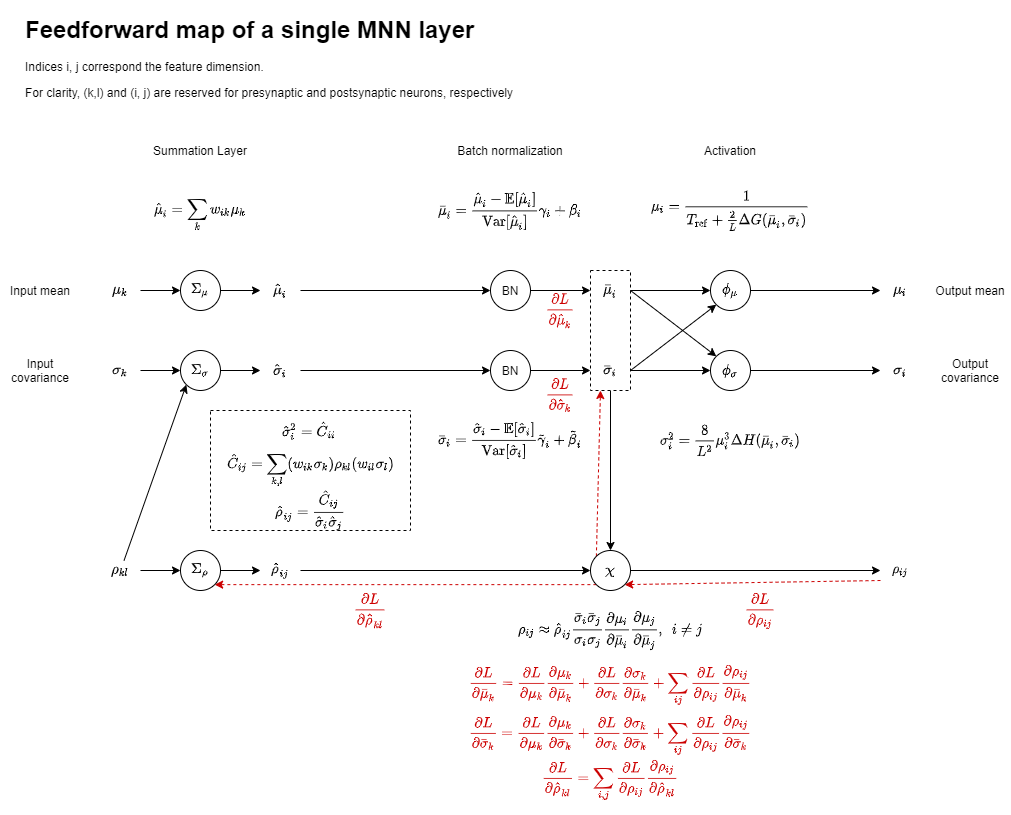

# 1. Summation layer

The summation layer $\Sigma: (\mu_k,\sigma_k,\rho_{kl})\to(\hat{\mu}_i,\hat{\sigma}_i,\hat{\rho}_{ij})$ is defined as

$\hat{\mu}_i = \sum_kw_{ik}\mu_k$  
$\hat{C}_{ij}=\sum_{kl}(w_{ik}\sigma_k) \rho_{kl} (w_{jl}\sigma_{l})$  
$\hat{\sigma}_i = \sqrt{\hat{C}_{ii}}$  
$
\hat{\rho}_{ij} = 
\dfrac{ C_{ij} }
{ \hat{\sigma}_i\hat{\sigma}_j }
$

These operations can be implemented with `torch.tensordot` and the gradients can be traced automatically by pytorch. Since $\sigma_i^2$ is just the diagonal entires of the covariance matrix and the division by $\hat{\sigma}_i$ is a potential liability for numeric stability, it is tempting to use the covariance matrix $C$ instead of the correlation coefficient $\rho$. However, we find that sticking with $\rho$ is a better way as it saves a lot of trouble later.

## 2. Batch normalization
Batch normalization are applied to $\hat{\mu}_i$ and $\hat{\sigma}_i$ separately using the default pytorch implementation. No batchnorm is required for the correlation coefficient.
- Apply standard batchnorm to $\hat{\mu}_i$  
    ${\rm BN}_\mu: \hat{\mu}_i\to\bar{\mu_i}$
- Apply standard batchnorm to $\hat{\sigma}_i$  
    ${\rm BN}_\sigma: \hat{\sigma}_i\to\bar{\sigma_i}$
    
The gradients for this layer is traced automatically by pytorch.   
(To improve: standard deviation should be normalized by the same $\gamma_i$ for normalizing the mean.)

## 4. Activation
The activation function consists of three maps   
- $\phi_\mu: (\bar{\mu}_i,\bar{\sigma}_i)\to\mu_i$  
- $\phi_\sigma: (\bar{\mu}_i,\bar{\sigma}_i)\to\sigma_i$  
- $\phi_\rho: (\bar{\mu},\bar{\sigma},\hat{\rho})\to\rho_{ij}$

The corresponding backward pass requires the following gradients which have to be manually defined.  
- $
\dfrac{\partial L}{\partial \bar{\mu}_k} = \dfrac{\partial L}{\partial \mu_k}\dfrac{\partial \mu_k}{\partial \bar{\mu}_k}
+\dfrac{\partial L}{\partial \sigma_k}\dfrac{\partial \sigma_k}{\partial \bar{\mu}_k}
+\sum_{ij}\dfrac{\partial L}{\partial \rho_{ij}}\dfrac{\partial \rho_{ij}}{\partial \bar{\mu}_k}
$
- $\dfrac{\partial L}{\partial \bar{\sigma}_k} = \dfrac{\partial L}{\partial \mu_k}\dfrac{\partial \mu_k}{\partial \bar{\sigma}_k}
+\dfrac{\partial L}{\partial \sigma_k}\dfrac{\partial \sigma_k}{\partial \bar{\sigma}_k}
+\sum_{ij}\dfrac{\partial L}{\partial \rho_{ij}}\dfrac{\partial \rho_{ij}}{\partial \bar{\sigma}_k}
$
- $\dfrac{\partial L}{\partial \hat{\rho}_{kl}} = \sum_{ij}\dfrac{\partial L}{\partial \rho_{ij}}\dfrac{\partial \rho_{ij}}{\partial \hat{\rho}_{kl}}$

Note for clarity we reserve indices $i, j$ for deeper layers and $k, l$ for shallower layers.

### i. Activation $\phi_\mu$ and its gradient  
The forward pass is defined as  
$\mu_i = \dfrac{1}{T_{\rm ref} + \langle T_i\rangle}$, 

$\langle T_i\rangle = \frac{2}{L}[G(I_i^{\rm ub})-G(I_i^{\rm lb})]$,  

$I_i^{\rm ub} = \dfrac{ V_{\rm th}L - \bar{\mu}_i }{ \max(\epsilon,\bar{\sigma}_i) },~~I_i^{\rm lb} = \dfrac{ V_{\rm ref}L - \bar{\mu}_i }{ \max(\epsilon,\bar{\sigma}_i) }$,  

where $G(x)$ is a fixed function (see Appendix). The denominators in $I_i^{\rm ub}$ and $I_i^{\rm lb}$ are rectified with $\epsilon >0 $ to eliminate potential zero divident error.

The gradients are

$\dfrac{\partial \mu_i}{\partial\bar{\mu_i}} = -\mu_i^2 \dfrac{\partial \langle T_i\rangle}{\partial \bar{\mu_i}} = -\frac{2}{L}\mu^2_i[g(I_i^{\rm ub})\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\mu_i}}-g(I_i^{\rm lb})\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\mu}_i}] = \dfrac{2\mu_{i}^{2}}{\overline{\sigma}_{i}L}(g(I_{i}^{ub})-g(I_i^{lb})$,  

where  
$\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\mu}_i} =\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\mu}_i} = -\dfrac{1}{\max(\epsilon,\bar{\sigma}_i)}$.

Similalry,  

$\dfrac{\partial \mu_i}{\partial\bar{\sigma}_i} = -\mu^2 \dfrac{\partial \langle T_i\rangle}{\partial \bar{\sigma}_i} = -\frac{2}{L}\mu_i^2[g(I_i^{\rm ub})\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\sigma}_i}-g(I_i^{\rm lb})\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\sigma}_i}] = \dfrac{2\mu_i^2}{\overline{\sigma}_i L}(I_i^{up}g(I_i^{ub})-I_i^{lb}g(I_i^{lb}))$  

where  

$\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\sigma}_i} = - \dfrac{ V_{\rm th}L - \bar{\mu}_i }{[ \max(\epsilon,\bar{\sigma}_i)]^2 }\mathbb{1}_{\sigma_i>\epsilon}$ 

$\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\sigma}_i} = - \dfrac{ V_{\rm ref}L - \bar{\mu}_i }{[ \max(\epsilon,\bar{\sigma}_i)]^2 }\mathbb{1}_{\sigma_i>\epsilon}$ 

### ii. Activation $\phi_\sigma$ and its gradient 
The forward pass is defined as

$\sigma_i^2 = \mu_i^3 {\rm Var} [T_i] = \frac{8}{L^2}\mu_i^3 [H(I_i^{\rm ub})-H(I_i^{\rm lb})]$,

$I_i^{\rm ub} = \dfrac{ V_{\rm th}L - \bar{\mu}_i }{ \max(\epsilon,\bar{\sigma}_i) },~~I_i^{\rm lb} = \dfrac{ V_{\rm ref}L - \bar{\mu}_i }{ \max(\epsilon,\bar{\sigma}_i) }$,

The derivatives are  
$\dfrac{\partial \sigma_i}{\partial \bar{\mu}_i} = -\frac{3}{L}\sigma_i\mu_i[g(I_i^{\rm ub})\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\mu}_i}-g(I_i^{\rm lb})\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\mu}_i}]+\frac{\sigma_i}{2\Delta H_i} [h(I_i^{\rm ub})\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\mu}_i}-h(I_i^{\rm lb})\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\mu}_i}]$  

$\dfrac{\partial \sigma_i}{\partial \bar{\sigma}_i} = -\frac{3}{L}\sigma_i\mu_i[g(I_i^{\rm ub})\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\sigma}_i}-g(I_i^{\rm lb})\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\sigma}_i}]+\frac{\sigma_i}{2\Delta H_i} [h(I_i^{\rm ub})\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\sigma}_i}-h(I_i^{\rm lb})\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\sigma}_i}]$



### iii. Activation $\phi_\rho$ and its gradient 
The forward pass is defined as

$\rho_{ij} = \chi(\bar{\mu}_i,\bar{\sigma}_i)\chi(\bar{\mu}_j,\bar{\sigma}_j) \hat{\rho}_{ij}
,~~i\neq j,
$  
where  
$
\chi_i = \chi(\bar{\mu_i},\bar{\sigma}_i)=\dfrac{\bar{\sigma}_i}{\sigma_i} 
\dfrac{\partial \mu_i}{\partial \bar{\mu}_i}
$  
is the linear response coefficient (see Appendix B for details). For $i=j$, we have $\rho_{ij}=1$.

For the backward pass we need to calculate the derivative of $\rho_{ij}$ with respect to $\bar{\mu}_k$, $\bar{\sigma}_k$, and $\hat{\rho}_{kl}$.

#### Case 1. $ \partial \rho_{ij} /\partial\bar{\mu}_{k}$  
$\dfrac{\partial \rho_{ij}}{\partial\bar{\mu}_{k}} 
=\hat{\rho}_{ij}\left(
\chi_j\dfrac{\partial \chi_i}{\partial \bar{\mu}_k}
+\chi_i\dfrac{\partial \chi_j}{\partial \bar{\mu}_k}
\right)$

Therefore, the following backprop gradient holds  
$
\sum_{ij}\dfrac{\partial L}{\partial \rho_{ij}}\dfrac{\partial \rho_{ij}}{\partial \bar{\mu}_k}
= \sum_{j} \dfrac{\partial L}{\partial \rho_{kj}}\hat{\rho}_{kj}\chi_j\dfrac{\partial \chi_k}{\partial \bar{\mu}_k}
+\sum_{i} \dfrac{\partial L}{\partial \rho_{ik}}\hat{\rho}_{ik}\chi_i\dfrac{\partial \chi_k}{\partial \bar{\mu}_k}
= 2\dfrac{\partial \chi_k}{\partial \bar{\mu}_k}\sum_{j}\dfrac{\partial L}{\partial \rho_{kj}}\hat{\rho}_{kj}\chi_j
$

#### Case 2. $ \partial \rho_{ij} /\partial\bar{\sigma}_{k}$  
$\dfrac{\partial \rho_{ij}}{\partial\bar{\sigma}_{k}} 
=\hat{\rho}_{ij}\left(
\chi_j\dfrac{\partial \chi_i}{\partial \bar{\sigma}_k}
+\chi_i\dfrac{\partial \chi_j}{\partial \bar{\sigma}_k}
\right)$

Therefore, the following backprop gradient holds  
$
\sum_{ij}\dfrac{\partial L}{\partial \rho_{ij}}\dfrac{\partial \rho_{ij}}{\partial \bar{\sigma}_k}
= \sum_{j} \dfrac{\partial L}{\partial \rho_{kj}}\hat{\rho}_{kj}\chi_j\dfrac{\partial \chi_k}{\partial \bar{\sigma}_k}
+\sum_{i} \dfrac{\partial L}{\partial \rho_{ik}}\hat{\rho}_{ik}\chi_i\dfrac{\partial \chi_k}{\partial \bar{\sigma}_k}
=2\dfrac{\partial \chi_k}{\partial \bar{\sigma}_k} \sum_{j}\dfrac{\partial L}{\partial \rho_{kj}}\hat{\rho}_{kj}\chi_j
$

#### Case 3. $\partial \rho_{ij}/\partial \hat{\rho}_{kl}$
This is simply  
$\dfrac{\partial \rho_{ij}}{\partial \hat{\rho}_{kl}}
=\chi_i\chi_j
$  
for $(i,j)=(k,l)$ or $(j,i)=(k,l)$ and $i\neq j$; and  
$\dfrac{\partial \rho_{ij}}{\partial \hat{\rho}_{kl}}=0$  
otherwise. 

Therefore, the following backprop gradient holds  
$
\dfrac{\partial L}{\partial \hat{\rho}_{kl}}
=\sum_{ij}\dfrac{L}{\partial \rho_{ij}}\dfrac{\partial \rho_{ij}}{\partial \hat{\rho}_{kl}}
=2\chi_k\chi_l\dfrac{\partial L}{\partial \rho_{kl}}
$  
for $k\neq l$.

***

## Appendix A: Generalized Dawson functions

$ g(x) = e^{x^2} \displaystyle\int_{-\infty}^x e^{-t^2}dt $    
$ G(x) = \displaystyle\int_{0}^x g(t) dt $    
$ h(x) = e^{x^2} \displaystyle\int_{-\infty}^x e^{-t^2}g(t)^2dt $  
$ H(x) = \displaystyle\int_{-\infty}^x h(t) dt $    

Special properties:  

$g'(x) = 2xg(x)+1$  
$h'(x) = 2xh(x)+g(x)^2$

We propose a stable numeric implementation of these integrals based on asymptotic expansions (not documented here).

## Appendix B: Linear response coefficient and its derivatives

$
\chi_i=\chi(\bar{\mu}_i,\bar{\sigma}_i)
=\dfrac{\bar{\sigma}_i}{\sigma_i} \dfrac{\partial \mu_i}{\partial \bar{\mu}_i}
=\dfrac{\bar{\sigma}_i}{\sigma_i}\left(
\frac{2}{L}\mu_i^2
\dfrac{\Delta g_i }
{\bar{\sigma}_i}
\right)
= \frac{2}{L}\dfrac{\mu_i^2}{\sigma_i}\Delta g_i
$  

$\dfrac{\partial \chi_i}{\partial \bar{\mu}_i}
= \dfrac{2}{L}\left\{
\left[2\mu_i\dfrac{\partial \mu_i}{\partial\bar{\mu}_i} - \dfrac{\mu_i^2}{\sigma^2_i}\dfrac{\partial \sigma_i}{\partial \bar{\mu}_i}\right]\Delta g_i
+2\dfrac{\mu^2_i}{\sigma_i}\left[
I_i^{\rm ub}g(I_i^{\rm ub})\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\mu}_i} - I_i^{\rm lb}g(I_i^{\rm lb})\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\mu}_i}
\right]
\right\}
$

$\dfrac{\partial \chi_i}{\partial \bar{\sigma}_i}
= \dfrac{2}{L}\left\{
\left[2\mu_i\dfrac{\partial \mu_i}{\partial\bar{\sigma}_i} - \dfrac{\mu_i^2}{\sigma^2_i}\dfrac{\partial \sigma_i}{\partial \bar{\sigma}_i}\right]\Delta g_i
+2\dfrac{\mu^2_i}{\sigma_i}\left[
I_i^{\rm ub}g(I_i^{\rm ub})\dfrac{\partial I_i^{\rm ub}}{\partial \bar{\sigma}_i} - I_i^{\rm lb}g(I_i^{\rm lb})\dfrac{\partial I_i^{\rm lb}}{\partial \bar{\sigma}_i}
\right]
\right\}
$

## Appendix C: Proof that batchnorm does not change $\hat{\rho}_{ij}$  
Recall that the activity of a neuron is approximated by a Gaussian random variable $X_i$. The pre-synaptic input is  
$Y_i = \sum_j w_{ij} X_j$,  
which is another Gaussian random variable.

Batchnorm effectively performs the transformation  
$Z_i = a_iY_i+b_i$,  
where $a_i$ and $b_i$ are some constants depending on the batch statistics (but not the layer statistics).

The covariance of $Z_i$ is   
${\rm Cov} [Z_i,Z_j] = a_ia_j{\rm Cov} [Y_i,Y_j]$.  
The standard deviation is therefore  
$\bar{\sigma}_i = a_i\hat{\sigma}_i$.  
Finally, we obtain the correlation coefficient  
$\bar{\rho}_{ij} =\dfrac{{\rm Cov} [Z_i,Z_j]}{\bar{\sigma_i}\bar{\sigma_j}} = \dfrac{{\rm Cov} [Y_i,Y_j]}{\hat{\sigma_i}\hat{\sigma_j}} = \hat{\rho}_{ij}$  
This shows that the batchnorm layer does not affect the correlation coefficient.